# Training regression models for unhealthy brain tissue using 55/100 CpG sites

- This workbook trains the linear, lasso and ridge regression models for the Alzheimer's and Huntington's cohorts using the 55/100 shared CpG sites from the HC brain XGBoost list
- Data used was created in thebrain_applying_hc_models.ipynb notebook and saved as alz_55_no_na.csv and hunt_55_no_na.csv


In [15]:
import _pickle as cPickle
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
from xgboost import XGBRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

### Reading in data

In [2]:
huntingtons_df=pd.read_csv('../huntingtons/hunt_brain_top_56.csv',index_col=0)  

In [3]:
alzheimers_df=pd.read_csv('../alzheimers/alz_brain_top_56.csv',index_col=0)  

In [4]:
huntingtons_df=huntingtons_df.drop(columns=['ch.1.169608016R'])
alzheimers_df=alzheimers_df.drop(columns=['ch.1.169608016R'])   

In [5]:
def apply_model_and_plot(model,X,y,mod_name,group):
    #model is: mod_56_whole_blood 

    # Make predictions and evaluate
    preds_y = model.predict(X)
    rms = sqrt(mean_squared_error(y, preds_y))
    r2 = r2_score(y, preds_y)
    mae = mean_absolute_error(y,preds_y)

    # Plot 

    plt.scatter(y, preds_y, alpha=0.5)
    plt.plot(range(0,120), range(0,120), c='red')
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.grid(True, lw=1.5, ls='--', alpha=0.75)
    plt.title(str(mod_name)+' on '+str(group))
    #a='rMSE:'+str(round(rms,3))
    b='MAE:'+str(round(mae,3))
    #plt.text(80, 15,'$%s$'%a,fontsize='large')
    plt.text(80, 1,'$%s$'%b,fontsize='large')
    plt.show()

    # print metric
    print(f'rMSE:{rms:.3f} years')
    print(f'r^2:{r2:.3f}')


### Defining the models

In [8]:
def lassoCV_regress(X_train,  X_test, y_train,y_test, plot=True, xmin=0,xmax=120,alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = mod = LassoCV(alphas=alphas,cv=cv)
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_test = mean_absolute_error(y_test,preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[1].scatter(y_train, preds_train, alpha=0.5)
        ax[1].plot(range(xmin,xmax), range(xmin,xmax), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
    
        ax[1].set_title('Lasso Regression on training data')
        

        ax[0].scatter(y_test, preds_test, alpha=0.5)
        ax[0].plot(range(xmin,xmax), range(xmin,xmax), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        b='MAE:'+str(round(mae_test,3))
        ax[0].text(80, 1,'$%s$'%b,fontsize='large')
        ax[0].set_title('Lasso Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [46]:
def linear_regress(X_train,  X_test, y_train, y_test, plot=True,xmin=0,xmax=120):
    
    #Build fit model
    mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs='None')
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = sqrt(mean_squared_error(y_train, preds_train))
    rms_test = sqrt(mean_squared_error(y_test, preds_test))
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_test = mean_absolute_error(y_test,preds_test)
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[1].scatter(y_train, preds_train, alpha=0.5)
        ax[1].plot(range(xmin,xmax), range(xmin,xmax), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Linear Regression on training data')

        ax[0].scatter(y_test, preds_test, alpha=0.5)
        ax[0].plot(range(xmin,xmax), range(xmin,xmax), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        b='MAE:'+str(round(mae_test,3))
        ax[0].text(80, 1,'$%s$'%b,fontsize='large')
        ax[0].set_title('Linear Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    
    return mod

In [20]:
def ridge_regress(X_train,  X_test, y_train,y_test, plot=True, xmin=0,xmax=120,alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5],cv=5):

    #Build fit model
    mod = Ridge()
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    mae_test = mean_absolute_error(y_test,preds_test)
    
    # Plot final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,4))
        ax[1].scatter(y_train, preds_train, alpha=0.5)
        ax[1].plot(range(xmin,xmax), range(xmin,xmax), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Ridge Regression on training data')

        ax[0].scatter(y_test, preds_test, alpha=0.5)
        ax[0].plot(range(xmin,xmax), range(xmin,xmax), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        b='MAE:'+str(round(mae_test,3))
        ax[0].text(80, 1,'$%s$'%b,fontsize='large')
        ax[0].set_title('Ridge Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    
    return mod, rms_train, rms_test, r2_train, r2_test

In [21]:
def mean_impute(data):
    nas=data.isnull().sum()    
    col_means=data.mean(axis=0)
    na_cols=[]
    na_cols_means=[]

    for i in range(len(nas)):
        if nas[i]!=0:        
            na_cols.append(nas.keys()[i])
            na_cols_means.append(col_means[i])
        
    ids=list(data.index)
    for i in ids:
        for j in range(len(na_cols)):
            if str(data.loc[i][na_cols[j]])=="nan":
                data.loc[i][na_cols[j]]=na_cols_means[j]
    
    
    return data

## Alzheimer's

### Test-held out split

In [22]:
X_alz = alzheimers_df.iloc[:, 1:]
y_alz = alzheimers_df[['AGE']]
X_work_alz, X_held_out_alz, Y_work_alz, Y_held_out_alz = train_test_split(X_alz, y_alz, test_size=0.25, random_state = 4, shuffle=True)
X_held_out_alz=mean_impute(X_held_out_alz)

### Test-train split

In [24]:
X_train_alz, X_test_alz, Y_train_alz, Y_test_alz = train_test_split(X_work_alz, Y_work_alz, test_size=0.25, random_state = 11, shuffle=True)

In [25]:
X_train_alz=mean_impute(X_train_alz)
X_test_alz=mean_impute(X_test_alz)

### Linear 

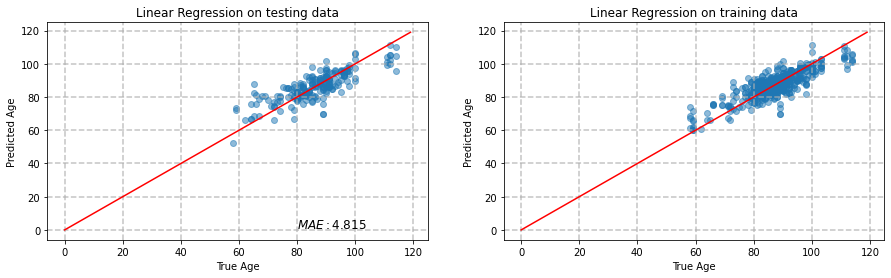

The rms on the training data is 5.386 years
The rms on the testing data is 6.380 years
The r^2 on the training data is 0.710
The r^2 on the testing data is 0.657


In [47]:
mod_55_brain_alz=linear_regress(X_train_alz, X_held_out_alz, Y_train_alz, Y_held_out_alz,xmin=0,xmax=120)

### Lasso 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


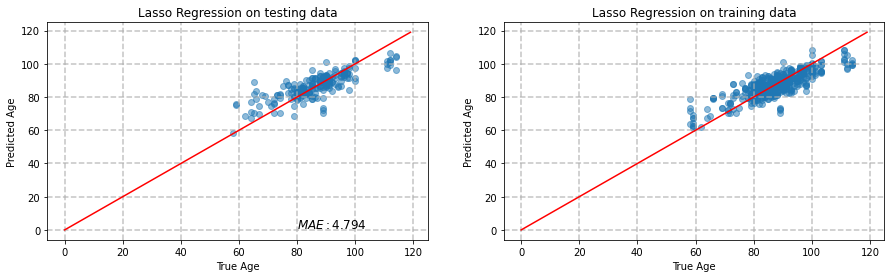

The rms on the training data is 5.702 years
The rms on the testing data is 6.499 years
The r^2 on the training data is 0.676
The r^2 on the testing data is 0.644


(LassoCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0,
                 10000.0, 100000.0],
         cv=5),
 5.70179022083662,
 6.499420696254809,
 0.6755352750200048,
 0.6437991537290662)

In [28]:
lassoCV_regress(X_train_alz, X_held_out_alz, Y_train_alz, Y_held_out_alz,xmin=0,xmax=120)

### Ridge

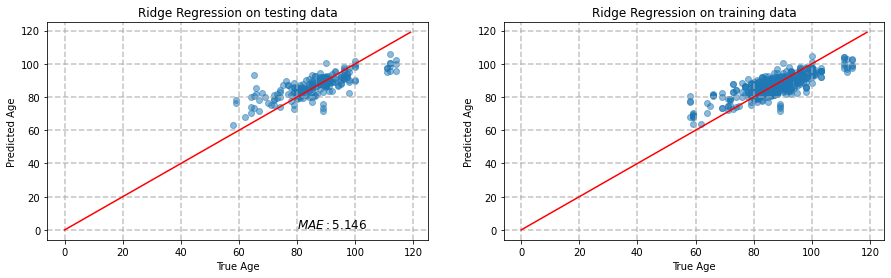

The rms on the training data is 6.124 years
The rms on the testing data is 7.033 years
The r^2 on the training data is 0.626
The r^2 on the testing data is 0.583


(Ridge(),
 6.123760818927375,
 7.032774168910417,
 0.6257330671166459,
 0.5829395641740605)

In [29]:

ridge_regress(X_train_alz, X_held_out_alz, Y_train_alz, Y_held_out_alz,xmin=0,xmax=120)

## Huntington's

### Test-train split

In [31]:
X_hunt = huntingtons_df.iloc[:, 1:]
y_hunt = huntingtons_df[['AGE']]
X_work_hunt, X_held_out_hunt, Y_work_hunt, Y_held_out_hunt = train_test_split(X_hunt, y_hunt, test_size=0.25, random_state = 4, shuffle=True)
X_held_out_hunt=mean_impute(X_held_out_hunt)

In [32]:
X_train_hunt, X_test_hunt, Y_train_hunt, Y_test_hunt = train_test_split(X_work_hunt, Y_work_hunt, test_size=0.25, random_state = 11, shuffle=True)
X_train_hunt=mean_impute(X_train_hunt)
X_test_hunt=mean_impute(X_test_hunt)

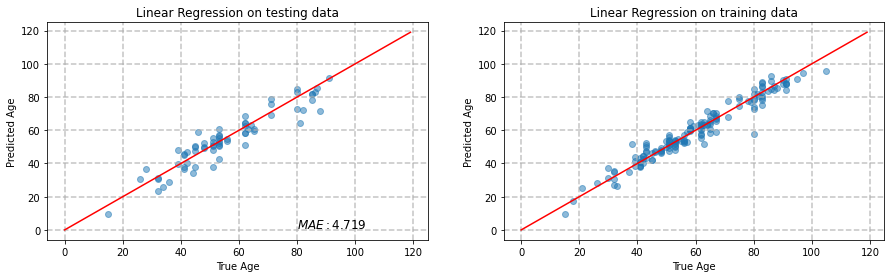

The rms on the training data is 4.249 years
The rms on the testing data is 6.001 years
The r^2 on the training data is 0.945
The r^2 on the testing data is 0.877


In [48]:
mod_55_brain_hunt=linear_regress(X_train_hunt, X_held_out_hunt, Y_train_hunt, Y_held_out_hunt,xmin=0,xmax=120)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


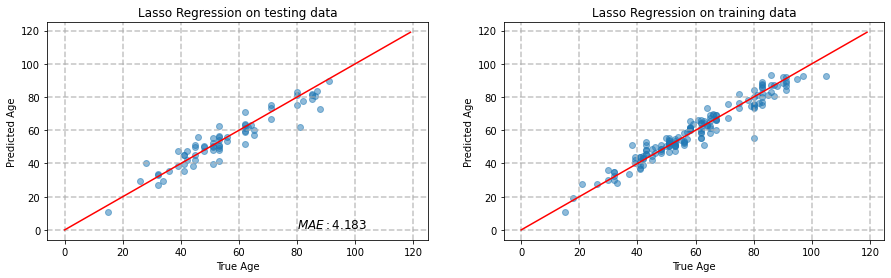

The rms on the training data is 4.530 years
The rms on the testing data is 5.602 years
The r^2 on the training data is 0.938
The r^2 on the testing data is 0.893


(LassoCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0,
                 10000.0, 100000.0],
         cv=5),
 4.530264141304033,
 5.6017098164503505,
 0.9378573758938107,
 0.8925237749545792)

In [36]:
lassoCV_regress(X_train_hunt, X_held_out_hunt, Y_train_hunt, Y_held_out_hunt,xmin=0,xmax=120)

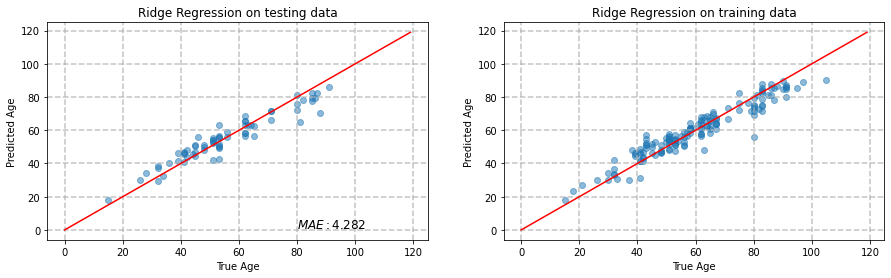

The rms on the training data is 5.540 years
The rms on the testing data is 5.432 years
The r^2 on the training data is 0.907
The r^2 on the testing data is 0.899


(Ridge(),
 5.540421072951109,
 5.432310790719472,
 0.9070545608317877,
 0.8989257781719827)

In [37]:
ridge_regress(X_train_hunt, X_held_out_hunt, Y_train_hunt, Y_held_out_hunt,xmin=0,xmax=120)

### Weights comparison

In [49]:
mod_55_brain_hc = pd.read_pickle(r'../models/mod_55_brain')
mod_55_brain_alz = mod_55_brain_alz
mod_55_brain_hunt = mod_55_brain_hunt
x=list(alzheimers_df.columns)[1:]

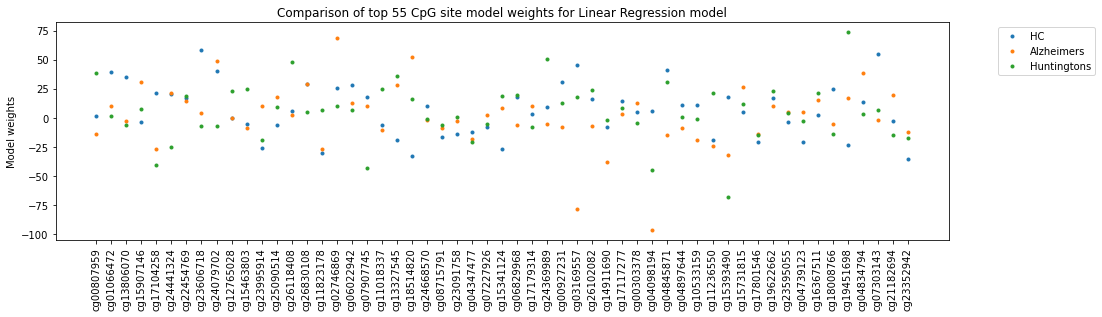

In [78]:
plt.figure(figsize=(16, 4))
plt.plot(x,mod_55_brain_hc.coef_,'.',label='HC')
plt.plot(x,mod_55_brain_alz.coef_[0],'.',label='Alzheimers')
plt.plot(x,mod_55_brain_hunt.coef_[0],'.',label='Huntingtons')
plt.ylabel('Model weights')
plt.title('Comparison of top 55 CpG site model weights for Linear Regression model')
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')